In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


In [ ]:
pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 26.0 MB/s eta 0:00:00


In [ ]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
import transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer, AutoModel
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, BartForConditionalGeneration
from transformers import DataCollatorForSeq2Seq, AdamW, get_linear_schedule_with_warmup
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import create_optimizer, AdamWeightDecay
from transformers import pipeline


In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import datasets
from datasets import Dataset, DatasetDict
from tqdm.auto import tqdm

In [ ]:
pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=6bcb620c5756ac8aca2727dd2102f620902bacc262240abc360b5926d13bbf92
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
df = pd.read_csv("news_summary.csv", encoding="latin-1")
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [ ]:
df.describe()

,author,date,headlines,read_more,text,ctext
count,4514,4514,4514,4514,4514,4396
unique,45,240,4514,4461,4514,4341
top,Chhavi Tyagi,"19 Jul 2017,Wednesday",More than half of India's languages may die in...,http://indiatoday.intoday.in/story/assembly-el...,At least 400 languages or more than half langu...,AAJ TAK LIVE TV WITH LIVE ELECTION RESULTS I c...
freq,559,76,1,13,1,13


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author     4514 non-null   object
 1   date       4514 non-null   object
 2   headlines  4514 non-null   object
 3   read_more  4514 non-null   object
 4   text       4514 non-null   object
 5   ctext      4396 non-null   object
dtypes: object(6)
memory usage: 211.7+ KB


In [ ]:
df = df[['headlines', 'text', 'ctext']]
df.head()

,headlines,text,ctext
0,Daman & Diu revokes mandatory Rakshabandhan in...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika slams user who trolled her for 'divorc...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,'Virgin' now corrected to 'Unmarried' in IGIMS...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Aaj aapne pakad liya: LeT man Dujana before be...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotel staff to get training to spot signs of s...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [ ]:
df = df.dropna()
df.describe()

,headlines,text,ctext
count,4396,4396,4396
unique,4396,4396,4341
top,More than half of India's languages may die in...,At least 400 languages or more than half langu...,AAJ TAK LIVE TV WITH LIVE ELECTION RESULTS I c...
freq,1,1,13


In [ ]:
df['ctext'] = df['ctext'].apply(str.lower)
df['text'] = df['text'].apply(str.lower)
df['headlines'] = df['headlines'].apply(str.lower)
df.head()

,headlines,text,ctext
0,daman & diu revokes mandatory rakshabandhan in...,the administration of union territory daman an...,the daman and diu administration on wednesday ...
1,malaika slams user who trolled her for 'divorc...,malaika arora slammed an instagram user who tr...,"from her special numbers to tv?appearances, bo..."
2,'virgin' now corrected to 'unmarried' in igims...,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...
3,aaj aapne pakad liya: let man dujana before be...,lashkar-e-taiba's kashmir commander abu dujana...,lashkar-e-taiba's kashmir commander abu dujana...
4,hotel staff to get training to spot signs of s...,hotels in maharashtra will train their staff t...,hotels in mumbai and other indian cities are t...


In [ ]:
df['headlines_length'] = [len(x.split()) for x in df.headlines]
df['text_length'] = [len(x.split()) for x in df.text]
df['ctext_length'] = [len(x.split()) for x in df.ctext]
df.head()

,headlines,text,ctext,headlines_length,text_length,ctext_length
0,daman & diu revokes mandatory rakshabandhan in...,the administration of union territory daman an...,the daman and diu administration on wednesday ...,9,60,364
1,malaika slams user who trolled her for 'divorc...,malaika arora slammed an instagram user who tr...,"from her special numbers to tv?appearances, bo...",10,60,396
2,'virgin' now corrected to 'unmarried' in igims...,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...,8,60,335
3,aaj aapne pakad liya: let man dujana before be...,lashkar-e-taiba's kashmir commander abu dujana...,lashkar-e-taiba's kashmir commander abu dujana...,10,60,404
4,hotel staff to get training to spot signs of s...,hotels in maharashtra will train their staff t...,hotels in mumbai and other indian cities are t...,11,60,526


In [ ]:
df = df[df['ctext_length'] >= df['text_length']]
df.describe()

,headlines_length,text_length,ctext_length
count,4274.000000,4274.000000,4274.000000
mean,9.300889,58.299719,351.740056
std,1.407168,2.314246,358.884472
min,4.000000,44.000000,50.000000
25%,8.000000,57.000000,193.000000
50%,9.000000,59.000000,288.000000
75%,10.000000,60.000000,416.000000
max,14.000000,62.000000,12202.000000


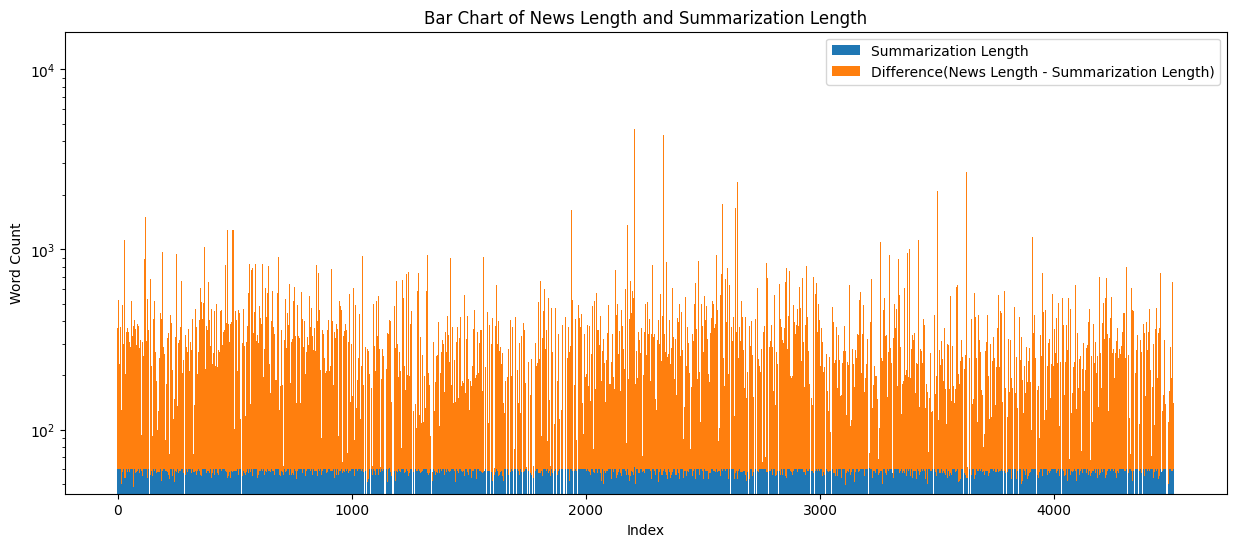

In [ ]:
df['diff'] = df['ctext_length'] - df['text_length']

plt.figure(figsize=(15, 6))
bar1 = plt.bar(df.index, df['text_length'], label='Summarization Length', width=1.0)
bar2 = plt.bar(df.index, df['diff'], bottom=df['text_length'], label='Difference(News Length - Summarization Length)', width=1.0)

plt.xlabel('Index')
plt.ylabel('Word Count')
plt.title('Bar Chart of News Length and Summarization Length')
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
df = df.drop(columns=['headlines_length', 'text_length', 'ctext_length', 'diff'])
df.head()

,headlines,text,ctext
0,daman & diu revokes mandatory rakshabandhan in...,the administration of union territory daman an...,the daman and diu administration on wednesday ...
1,malaika slams user who trolled her for 'divorc...,malaika arora slammed an instagram user who tr...,"from her special numbers to tv?appearances, bo..."
2,'virgin' now corrected to 'unmarried' in igims...,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...
3,aaj aapne pakad liya: let man dujana before be...,lashkar-e-taiba's kashmir commander abu dujana...,lashkar-e-taiba's kashmir commander abu dujana...
4,hotel staff to get training to spot signs of s...,hotels in maharashtra will train their staff t...,hotels in mumbai and other indian cities are t...


In [ ]:
df['news'] = df['headlines'] + '. ' + df['ctext']
df.rename(columns={"text": "summary"}, inplace = True)
df = df.drop(columns=['headlines', 'ctext'])
df.head()

,summary,news
0,the administration of union territory daman an...,daman & diu revokes mandatory rakshabandhan in...
1,malaika arora slammed an instagram user who tr...,malaika slams user who trolled her for 'divorc...
2,the indira gandhi institute of medical science...,'virgin' now corrected to 'unmarried' in igims...
3,lashkar-e-taiba's kashmir commander abu dujana...,aaj aapne pakad liya: let man dujana before be...
4,hotels in maharashtra will train their staff t...,hotel staff to get training to spot signs of s...


In [ ]:
prefix = 'summarize: '
df['news'] = prefix + df['news']
df.head()

,summary,news
0,the administration of union territory daman an...,summarize: daman & diu revokes mandatory raksh...
1,malaika arora slammed an instagram user who tr...,summarize: malaika slams user who trolled her ...
2,the indira gandhi institute of medical science...,summarize: 'virgin' now corrected to 'unmarrie...
3,lashkar-e-taiba's kashmir commander abu dujana...,summarize: aaj aapne pakad liya: let man dujan...
4,hotels in maharashtra will train their staff t...,summarize: hotel staff to get training to spot...


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.01, shuffle=True)
print("train and val shape:", train_df.shape, "test shape:",test_df.shape)

global_train_df = train_df
global_test_df = test_df
train_df = datasets.Dataset.from_pandas(train_df)
train_df = train_df.remove_columns(["__index_level_0__"])

# split train into train and val
train_df = train_df.train_test_split(test_size=0.2, shuffle=True) # split train and test
train_df["train"][0]

train and val shape: (4231, 2) test shape: (43, 2)


{'summary': 'with majority of toilets built under swachh bharat abhiyan lying unused, posters depicting characters like baahubali making their contribution towards cleanliness have been put up to push the campaign at indian railways. railways, with the help of a startup, has also put up hoardings appealing passengers to become like bhagat singh, among other national icons by keeping the country clean.',
 'news': 'summarize: swachh bharat campaign uses baahubali in promotional posters. with estimated 60 per cent of toilets built under swachh bharat mission lying unused, startups have come up to the rescue of the railway ministry with innovative communication module to induce behavioural changes in people. from national icons like mahatma gandhi, br ambedkar and bhagat singh to present-day heroes like baahubali, the module uses these characters to urge people to stop littering and defecating in public.a pilot project has been launched by a behavioural intervention startup, antyodaya grou

In [ ]:
train_val_test_dataset = DatasetDict({
    'train': train_df["train"],
    'val': train_df['test']})

print(type(train_val_test_dataset))
train_val_test_dataset

<class 'datasets.dataset_dict.DatasetDict'>


DatasetDict({
    train: Dataset({
        features: ['summary', 'news'],
        num_rows: 3384
    })
    val: Dataset({
        features: ['summary', 'news'],
        num_rows: 847
    })
})

**T5 Model:**

In [ ]:
model_name = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
def prepare_dataset(data):
    inputs = data["news"]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)
    labels = tokenizer(text_target=data["summary"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_data = train_val_test_dataset.map(prepare_dataset, batched=True)

Map:   0%|          | 0/3384 [00:00<?, ? examples/s]

Map:   0%|          | 0/847 [00:00<?, ? examples/s]

In [ ]:
tokenized_data["train"]

Dataset({
    features: ['summary', 'news', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 3384
})

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {
        'rouge1': [],
        'rouge2': [],
        'rougeL': []
    }

    for pred, label in zip(decoded_preds, decoded_labels):
        score = scorer.score(label, pred)
        for key in rouge_scores.keys():
            rouge_scores[key].append(score[key].fmeasure)

    result = {metric: np.mean(scores) for metric, scores in rouge_scores.items()}

    return result

In [ ]:
T5model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [ ]:
# hyper-parameters
training_args = Seq2SeqTrainingArguments(
    output_dir="t5-news",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
    gradient_checkpointing=True,
    report_to="none"
)
#trainer
trainer = Seq2SeqTrainer(
    model = T5model,
    args = training_args,
    train_dataset = tokenized_data["train"],
    eval_dataset = tokenized_data["val"],
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,No log,1.333569,0.237935,0.128180,0.201534
2,No log,1.305028,0.242771,0.134047,0.206600
3,5.805100,1.291440,0.245143,0.137819,0.209215


TrainOutput(global_step=844, training_loss=5.665003482764366, metrics={'train_runtime': 2119.0211, 'train_samples_per_second': 6.388, 'train_steps_per_second': 0.398, 'total_flos': 8113393365073920.0, 'train_loss': 5.665003482764366, 'epoch': 3.983451536643026})

In [ ]:
model_path = "t5-news"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('t5-news/tokenizer_config.json',
 't5-news/special_tokens_map.json',
 't5-news/spiece.model',
 't5-news/added_tokens.json',
 't5-news/tokenizer.json')

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained("t5-news")

In [ ]:
for i in range(5):
    print("original_news: ",test_df['news'].iloc[i])
    summarizer = pipeline("summarization", model = model,tokenizer = tokenizer, max_length = 100)
    summary = summarizer(test_df['news'].iloc[i])
    print(summary[0])
    print()

Device set to use cuda:0


original_news:  summarize: would like some animal spirit in indian entrepreneurs: kotak. from barun jha davos, jan 22 (pti) confident of india gaining its "rightful place" in coming years on the world stage alongside the us and china, ace banker uday kotak has said indian corporates also need to combine some "animal spirit" with their judicious capital allocation for their own business growth and add to the economys expansion. the kotak group chief, who has steered one of the most successful banking and financial services sector stories in recent years in india, also favoured nudge from the government and policymakers to the corporates to get that "animal spirit" and said the country should also incentivise delta jobs created in any country. kotak, who was here to attend the world economic forum annual meeting that saw china positioning itself as a new champion of globalisation, told pti in an interview that india has to take its rightful place over the next 5-10 years and the institut

Device set to use cuda:0


{'summary_text': 'ace banker uday kotak has said that indian corporates need to combine some "animal spirit" with their judicious capital allocation for their own business growth and add to the economy\'s expansion. he also favoured nudge from the government and policymakers to the corporates to get that \'animal spirits\' and said the country should also incentivise delta jobs created in any country.'}

original_news:  summarize: virat kohli receives padma shri at rashtrapati bhavan. virat kohli was today conferred with the padma shri award by president pranab mukherjee at a ceremony at the rashtrapati bhavan.besides kohli, hockey captain pr sreejesh and rio olympic silver medallist sakshi malik and gymnast dipa karmakar and fourth other sportspersons were conferred with the prestigious award. (padma shri award on republic day makes it even more special: virat kohli)what an absolute honor and a memorable day to receive the padma shri award from the president of india. god's been kind.

Device set to use cuda:0


{'summary_text': 'virat kohli was today conferred with the padma shri award by president pranab mukherjee at a ceremony at the rashtrapati bhavan. hockey captain pr sreejesh and rio olympic silver medallist sakshi malik, gymnast dipa karmakar and fourth other sportspersons were conferred the prestigious award.'}

original_news:  summarize: want to explore my bisexuality after split: dakota johnson. hollywood actor dakota johnson, who split from model-singer matthew hitt last year, says she is now planning to explore bisexuality.johnson, who is gearing up for the release of her latest film fifty shades darker, has graced the cover of vogue magazine for its february issue.watch: vin diesel calls ranveer deepika's boyfriendalso read: xxx return of xander cage reviewspeaking about her split, johnson said:,"s**t happens."she further opened up and said, "i think i'm a little bit heartbroken all the time, even when i'm in a happy relationship. i don't do casual very well, and my feelings, eve

Device set to use cuda:0


{'summary_text': 'hollywood actress dakota johnson, who split from model-singer matthew hitt last year, said she is now planning to explore her bisexuality after her split. "i think i\'m a little bit heartbroken all the time, even when i am in a happy relationship. i don\'t do casual very well," she added.'}

original_news:  summarize: ensure children not hurt during muharram: bombay hc.  the bombay high court on monday directed the police to ensure that no minors are ?harmed, injured, or permitted to carry or use weapons or sharp objects,? during this year?s muharram procession.the court said that while it was not oblivious to religious practices, a ?fine balance? needed to be maintained between such practices and ensuring the safety of all participants.the bench also directed the additional commissioner of police, south region, to ?personally supervise? the procession this september and ensure that the court?s directions are complied with.the court was hearing a suo moto public inter

Device set to use cuda:0


{'summary_text': "the bombay high court on monday directed the police to ensure that no minors are 'harmed, injured, or permitted to carry or use weapons or sharp objects,' during this year's muharram procession. the court said that while it was not oblivious to religious practices, a 'fine balance' needed to be maintained between such practices and ensuring the safety of all participants."}

original_news:  summarize: gujarat vendor inspired by jio introduces unlimited panipuri. a chaatwalla from gujarat who got inspired from reliance jio's 4g plans came out with panipuri schemes to lure his customers.the porbandar-based vendor ravi jagdamba introduced a daily and monthly scheme in which for rs 100 and rs 1000 one can enjoy unlimited lip-smacking panipuris at the gujarati vendor's stall.also read: heartwarming: us youtuber distributes mcdonald cheeseburgers among the homelessjust like reliance jio, the chaatwalla's business is also in great demand now. the scheme actually worked for t